Dataset+dataloader

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageOps

# --- 1) Resize with padding (keeps anatomy proportions) ---
class ResizeWithPad:
    def __init__(self, size, fill=0):
        self.size = size if isinstance(size, tuple) else (size, size)
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        # Ensure PIL Image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)

        # Make thumbnail keeping aspect ratio
        img = ImageOps.contain(img, self.size)

        # Pad to target size
        pad_w = self.size[0] - img.size[0]
        pad_h = self.size[1] - img.size[1]
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        img = ImageOps.expand(img, padding, fill=self.fill)
        return img


def make_loaders(
    data_root,
    img_size=224,
    batch_size=16,
    num_workers=2,
):
    # ---- TRAIN transforms (with augmentation) ----
    train_tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        ResizeWithPad(img_size, fill=0),

        # Augmentations (train only)
        transforms.RandomAffine(
            degrees=15,
            translate=(0.08, 0.08),
            scale=(0.9, 1.1),
            shear=None
        ),
        transforms.ColorJitter(brightness=0.08, contrast=0.10),

        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.5], std=[0.5])  # -> roughly [-1, 1]
    ])

    # ---- TEST transforms (NO augmentation) ----
    test_tf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        ResizeWithPad(img_size, fill=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    train_dir = os.path.join(data_root, "train")
    test_dir  = os.path.join(data_root, "test")

    train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
    test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    print("Class mapping:", train_ds.class_to_idx)  # should show {'healthy':0,'tumor':1} or similar
    print("Train size:", len(train_ds), "Test size:", len(test_ds))

    return train_loader, test_loader, train_ds, test_ds


Sanity check

In [2]:
data_root = "/kaggle/input/test-dataset-1/test_dataset1"

train_loader, test_loader, train_ds, test_ds = make_loaders(
    data_root=data_root,
    img_size=224,
    batch_size=16,
    num_workers=2
)


Class mapping: {'healthy': 0, 'tumor': 1}
Train size: 40 Test size: 20


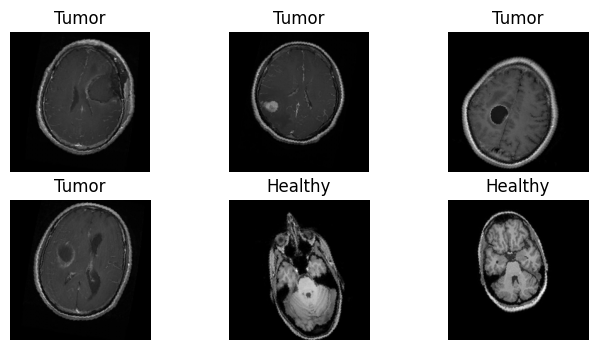

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title("Tumor" if labels[i]==1 else "Healthy")
    plt.axis("off")
plt.show()


ResNet18 feature extractor (1-channel safe)

In [4]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18FeatureExtractor(nn.Module):
    """
    ResNet18 backbone that outputs embeddings (B, 512).
    Modified to accept 1-channel MRI inputs.
    """
    def __init__(self, pretrained=True, train_backbone=True):
        super().__init__()

        # Load a ResNet18
        if pretrained:
            weights = models.ResNet18_Weights.DEFAULT
            backbone = models.resnet18(weights=weights)
        else:
            backbone = models.resnet18(weights=None)

        # ---- Modify first conv to accept 1 channel instead of 3 ----
        old_conv = backbone.conv1  # Conv2d(3, 64, ...)
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )

        # If pretrained, initialize new_conv weights from old_conv by averaging RGB weights
        if pretrained:
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

        backbone.conv1 = new_conv

        # ---- Remove classifier head: keep everything up to avgpool ----
        self.backbone = backbone
        self.backbone.fc = nn.Identity()  # now forward returns (B, 512)

        # Freeze backbone if you want (optional)
        if not train_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x):
        # x: (B, 1, 224, 224)
        emb = self.backbone(x)  # (B, 512)
        return emb


Quick sanity test

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn_feat = ResNet18FeatureExtractor(pretrained=True, train_backbone=True).to(device)
cnn_feat.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    emb = cnn_feat(images)

print("Input shape:", images.shape)   # (B, 1, 224, 224)
print("Embedding shape:", emb.shape)  # (B, 512)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Input shape: torch.Size([16, 1, 224, 224])
Embedding shape: torch.Size([16, 512])


From ResNet18 feature extractor, we already have: 
embeddings.shape = (B, 512)
These values:

are continuous (floats)

represent feature strength

are NOT spikes yet

Preprocessing embeddings for spike encoding

Before rate coding, we must ensure values are in [0, 1], because they will be used as firing probabilities.

In [6]:
import torch

def normalize_embeddings(emb):
    """
    Normalize embeddings to [0, 1] per batch.
    emb: (B, F)
    """
    emb_min = emb.min(dim=1, keepdim=True)[0]
    emb_max = emb.max(dim=1, keepdim=True)[0]
    return (emb - emb_min) / (emb_max - emb_min + 1e-6)


Rate-based spike encoding (core of Step 3)
Idea recap

Each feature value → firing probability

At each time step, generate a spike (0 or 1)

Repeat for T time steps

Implementation: Rate Coding Encoder

In [7]:
def rate_code(embeddings, T=10):
    """
    Rate-based spike encoding.

    embeddings: (B, F) tensor in [0,1]
    T: number of time steps

    returns:
        spikes: (T, B, F) binary tensor
    """
    B, F = embeddings.shape

    # Expand embeddings to (T, B, F)
    emb_expanded = embeddings.unsqueeze(0).repeat(T, 1, 1)

    # Random numbers in [0,1]
    rand_uniform = torch.rand(T, B, F, device=embeddings.device)

    # Spike generation
    spikes = (rand_uniform < emb_expanded).float()

    return spikes


**Full Step 3 pipeline (CNN → spikes)**

In [8]:
# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn_feat.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    emb = cnn_feat(images)              # (B, 512)
    emb_norm = normalize_embeddings(emb)
    spikes = rate_code(emb_norm, T=10)  # (T, B, 512)

print("Embeddings:", emb.shape)
print("Spike tensor:", spikes.shape)


Embeddings: torch.Size([16, 512])
Spike tensor: torch.Size([10, 16, 512])
